# **SVHN Classification using PyTorch Image Models**
In this notebook, we train three models on The Street View House Numbers (SVHN) Dataset using  PyTorch Image Models (timm) module. 

_Brief Description and Overview of the SVHN Dataset_

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

Overview:

*  10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
* 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data
* Comes in two formats:
  1. Original images with character level bounding boxes.
  2. MNIST-like 32-by-32 images centered around a single character (many of the images do contain some distractors at the sides).

(Source: http://ufldl.stanford.edu/housenumbers)

In [ ]:
# Load the necessary libraries
!pip install timm
import timm
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

**Load the SVHN dataset using torchvision**

Note: In this dataset, '0' has a label 0 instead of 10

In [ ]:
# Download our datasets and apply transforms using the torchvision module
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
data_transform = {'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/SVHN'
image_datasets = {x: datasets.SVHN(os.path.join(data_dir, x), split = x, transform = data_transform[x], download = True)
              for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 128,
                                             shuffle = True, num_workers = 0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print("Train dataset:", dataset_sizes['train'])
print("Test dataset:", dataset_sizes['test'])

class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Configure device to use GPU when available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using downloaded and verified file: data/SVHN/train/train_32x32.mat
Using downloaded and verified file: data/SVHN/test/test_32x32.mat
Train dataset: 73257
Test dataset: 26032


**Visualize sample images from the datasets**

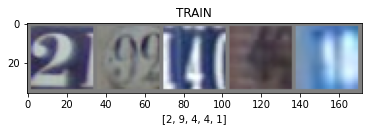

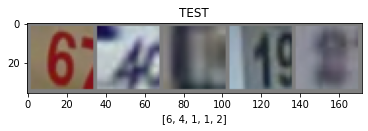

In [ ]:
def imshow(input, title, label = ''):
    input = input.numpy().transpose((1, 2, 0))
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.title(title.upper())
    plt.xlabel(label)
    plt.show()

num_samples = 5 # number of sample images to show
for x in ['train', 'test']:  
  # Get samples of data
  inputs, classes = next(iter(dataloaders[x]))
  # Make a grid using a number of samples (num_samples) from batch 
  out = torchvision.utils.make_grid(inputs[:num_samples], nrow  = num_samples)
  imshow(out, title = x, label = [class_names[name] for name in classes[:num_samples]])

**Train the model**

In this section, we write a function to train the model, track statistics and save the best model.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc = []
    train_loss = []
    validation_acc = []
    validation_loss = []
    time_hist = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs), end = " | ")
        epoch_start_time = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                    'Train', epoch_loss, epoch_acc), end = " | ")
            else:
                validation_loss.append(epoch_loss)
                validation_acc.append(epoch_acc)
                print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                    'Valid', epoch_loss, epoch_acc), end = " | ")
                if epoch_acc > best_acc:
                  # deep copy the model
                  best_acc = epoch_acc
                  best_model_weights = copy.deepcopy(model.state_dict())    
        time_epoch = time.time() - epoch_start_time
        print('{:.0f}m {:.0f}s'.format(time_epoch // 60, time_epoch % 60))
        time_hist.append(time_epoch)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model, train_acc, train_loss, validation_acc, validation_loss, time_hist

**Plot data**

In this section, we write a function to plot historical data of loss and accuracy.

In [ ]:
def plot_stat(epochs, train_acc, train_loss, validation_acc, validation_loss):
  plt.plot(range(1, epochs + 1), train_acc, color = 'y', label = 'Training acc')
  plt.plot(range(1, epochs + 1), validation_acc, color = 'r', label = 'Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(range(1, epochs + 1), train_loss, color = 'y', label = 'Training loss')
  plt.plot(range(1, epochs + 1), validation_loss, color = 'r', label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

#**Model 1:  Resnet-18**
Let us now load, train  and evaluate our first model, a pretrained ResNet-18 model.

Epoch 1/100 | Train Loss: 1.9793 Accuracy: 0.3104 | Valid Loss: 1.6468 Accuracy: 0.4330 | 0m 39s
Epoch 2/100 | Train Loss: 1.4022 Accuracy: 0.5227 | Valid Loss: 1.2031 Accuracy: 0.5975 | 0m 40s
Epoch 3/100 | Train Loss: 1.0581 Accuracy: 0.6414 | Valid Loss: 0.9369 Accuracy: 0.6885 | 0m 40s
Epoch 4/100 | Train Loss: 0.8594 Accuracy: 0.7106 | Valid Loss: 0.7952 Accuracy: 0.7362 | 0m 40s
Epoch 5/100 | Train Loss: 0.7312 Accuracy: 0.7566 | Valid Loss: 0.6933 Accuracy: 0.7720 | 0m 40s
Epoch 6/100 | Train Loss: 0.6432 Accuracy: 0.7853 | Valid Loss: 0.6204 Accuracy: 0.7968 | 0m 40s
Epoch 7/100 | Train Loss: 0.5769 Accuracy: 0.8100 | Valid Loss: 0.5750 Accuracy: 0.8135 | 0m 41s
Epoch 8/100 | Train Loss: 0.5283 Accuracy: 0.8274 | Valid Loss: 0.5401 Accuracy: 0.8244 | 0m 41s
Epoch 9/100 | Train Loss: 0.4842 Accuracy: 0.8428 | Valid Loss: 0.5069 Accuracy: 0.8383 | 0m 41s
Epoch 10/100 | Train Loss: 0.4513 Accuracy: 0.8526 | Valid Loss: 0.4827 Accuracy: 0.8467 | 0m 41s
Epoch 11/100 | Train Loss: 0.

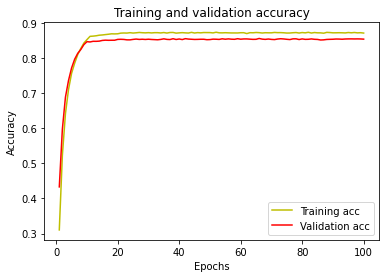

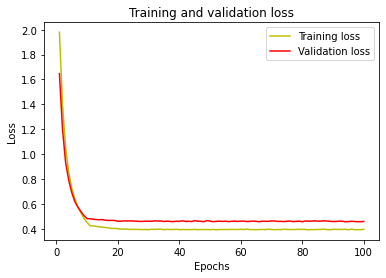

In [ ]:
# Load a pretrained model and reset final fully connected layer.
model = timm.create_model('resnet18', pretrained = True)
num_ftrs = model.fc.in_features

# Here the size of each output sample is set to 10.
num_output = 10
model.fc = nn.Linear(num_ftrs, num_output)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

epochs = 100
model, train_acc, train_loss, validation_acc, validation_loss, time_hist = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs = epochs)
plot_stat(epochs, train_acc, train_loss, validation_acc, validation_loss)

Epoch 1/100 | Train Loss: 1.9870 Accuracy: 0.3037 | Valid Loss: 1.6712 Accuracy: 0.4226 | 0m 41s
Epoch 2/100 | Train Loss: 1.4180 Accuracy: 0.5168 | Valid Loss: 1.2303 Accuracy: 0.5869 | 0m 41s
Epoch 3/100 | Train Loss: 1.0656 Accuracy: 0.6388 | Valid Loss: 0.9560 Accuracy: 0.6811 | 0m 41s
Epoch 4/100 | Train Loss: 0.8608 Accuracy: 0.7093 | Valid Loss: 0.7966 Accuracy: 0.7357 | 0m 41s
Epoch 5/100 | Train Loss: 0.7336 Accuracy: 0.7545 | Valid Loss: 0.6960 Accuracy: 0.7736 | 0m 41s
Epoch 6/100 | Train Loss: 0.6448 Accuracy: 0.7845 | Valid Loss: 0.6312 Accuracy: 0.7949 | 0m 41s
Epoch 7/100 | Train Loss: 0.5780 Accuracy: 0.8101 | Valid Loss: 0.5782 Accuracy: 0.8133 | 0m 41s
Epoch 8/100 | Train Loss: 0.5246 Accuracy: 0.8262 | Valid Loss: 0.5415 Accuracy: 0.8268 | 0m 41s
Epoch 9/100 | Train Loss: 0.4851 Accuracy: 0.8414 | Valid Loss: 0.5081 Accuracy: 0.8374 | 0m 41s
Epoch 10/100 | Train Loss: 0.4514 Accuracy: 0.8541 | Valid Loss: 0.4820 Accuracy: 0.8471 | 0m 41s
Epoch 11/100 | Train Loss: 0.

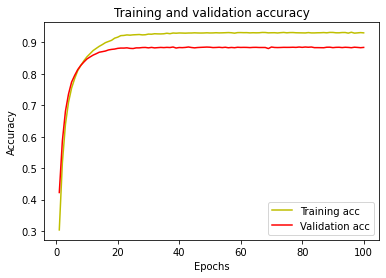

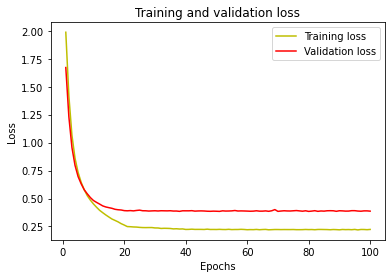

In [ ]:
# Load a pretrained model and reset final fully connected layer.
model = timm.create_model('resnet18', pretrained = True)
num_ftrs = model.fc.in_features

# Here the size of each output sample is set to 10.
num_output = 10
model.fc = nn.Linear(num_ftrs, num_output)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.001)
# Decay LR by a factor of 0.1 every 20 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

epochs = 100
model, train_acc, train_loss, validation_acc, validation_loss, time_hist = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs = epochs)
plot_stat(epochs, train_acc, train_loss, validation_acc, validation_loss)

In [ ]:
# Load a pretrained model
model_resnet18 = timm.create_model('resnet18', pretrained = True)

# Reset final fully connected layer and change the output size to 10
num_ftrs = model_resnet18.fc.in_features
num_output = 10
model_resnet18.fc = nn.Linear(num_ftrs, num_output)

model_resnet18 = model_resnet18.to(device)

# Use CrossEntropyLoss as criterion
criterion = nn.CrossEntropyLoss()
# Use SGD to optimize all parameters 
optimizer = optim.SGD(model_resnet18.parameters(), lr = 0.001)
# Decay LR by a factor of 0.5 every 20 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.5)

epochs = 100
model_resnet18, train_acc, train_loss, validation_acc, validation_loss, time_hist = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs = epochs)
plot_stat(epochs, train_acc, train_loss, validation_acc, validation_loss)

Epoch 1/100 | Train Loss: 1.9620 Accuracy: 0.3169 | Valid Loss: 1.6432 Accuracy: 0.4395 | 0m 47s
Epoch 2/100 | Train Loss: 1.3893 Accuracy: 0.5250 | Valid Loss: 1.1742 Accuracy: 0.6012 | 0m 47s
Epoch 3/100 | Train Loss: 1.0572 Accuracy: 0.6406 | Valid Loss: 0.9581 Accuracy: 0.6780 | 0m 47s
Epoch 4/100 | Train Loss: 0.8610 Accuracy: 0.7093 | Valid Loss: 0.8012 Accuracy: 0.7349 | 0m 47s
Epoch 5/100 | Train Loss: 0.7333 Accuracy: 0.7533 | Valid Loss: 0.6990 Accuracy: 0.7692 | 0m 47s
Epoch 6/100 | Train Loss: 0.6470 Accuracy: 0.7846 | Valid Loss: 0.6262 Accuracy: 0.7955 | 0m 47s
Epoch 7/100 | Train Loss: 0.5819 Accuracy: 0.8070 | Valid Loss: 0.5848 Accuracy: 0.8105 | 0m 47s
Epoch 8/100 | Train Loss: 0.5285 Accuracy: 0.8249 | Valid Loss: 0.5410 Accuracy: 0.8244 | 0m 47s
Epoch 9/100 | Train Loss: 0.4890 Accuracy: 0.8396 | Valid Loss: 0.5134 Accuracy: 0.8365 | 0m 47s
Epoch 10/100 | Train Loss: 0.4549 Accuracy: 0.8519 | Valid Loss: 0.4842 Accuracy: 0.8462 | 0m 47s
Epoch 11/100 | Train Loss: 0.

KeyboardInterrupt: ignored

Epoch 1/50 | Train Loss: 1.9823 Accuracy: 0.3094 | Valid Loss: 1.6429 Accuracy: 0.4403 | 0m 47s
Epoch 2/50 | Train Loss: 1.4056 Accuracy: 0.5206 | Valid Loss: 1.2054 Accuracy: 0.5909 | 0m 47s
Epoch 3/50 | Train Loss: 1.0614 Accuracy: 0.6410 | Valid Loss: 0.9446 Accuracy: 0.6864 | 0m 47s
Epoch 4/50 | Train Loss: 0.8593 Accuracy: 0.7121 | Valid Loss: 0.7940 Accuracy: 0.7371 | 0m 47s
Epoch 5/50 | Train Loss: 0.7352 Accuracy: 0.7545 | Valid Loss: 0.6954 Accuracy: 0.7702 | 0m 47s
Epoch 6/50 | Train Loss: 0.6667 Accuracy: 0.7781 | Valid Loss: 0.6878 Accuracy: 0.7754 | 0m 47s
Epoch 7/50 | Train Loss: 0.6589 Accuracy: 0.7802 | Valid Loss: 0.6781 Accuracy: 0.7772 | 0m 47s
Epoch 8/50 | Train Loss: 0.6536 Accuracy: 0.7839 | Valid Loss: 0.6713 Accuracy: 0.7794 | 0m 47s
Epoch 9/50 | Train Loss: 0.6418 Accuracy: 0.7867 | Valid Loss: 0.6693 Accuracy: 0.7812 | 0m 47s
Epoch 10/50 | Train Loss: 0.6358 Accuracy: 0.7886 | Valid Loss: 0.6563 Accuracy: 0.7861 | 0m 47s
Epoch 11/50 | Train Loss: 0.6301 Accura

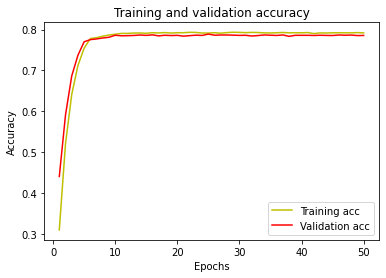

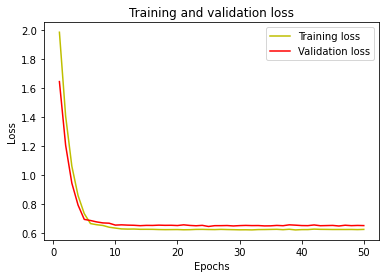

In [ ]:
# Load a pretrained model
model_resnet18 = timm.create_model('resnet18', pretrained = True)

# Reset final fully connected layer and change the output size to 10
num_ftrs = model_resnet18.fc.in_features
num_output = 10
model_resnet18.fc = nn.Linear(num_ftrs, num_output)

model_resnet18 = model_resnet18.to(device)

# Use CrossEntropyLoss as criterion
criterion = nn.CrossEntropyLoss()
# Use SGD to optimize all parameters 
optimizer = optim.SGD(model_resnet18.parameters(), lr = 0.001)
# Decay LR by a factor of 0.5 every 20 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

epochs = 50
model_resnet18, train_acc, train_loss, validation_acc, validation_loss, time_hist = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs = epochs)
plot_stat(epochs, train_acc, train_loss, validation_acc, validation_loss)

#**Model 2: EfficientNet-B3**
Let us now load, train  and evaluate our second model, a pretrained EfficientNet-B3 model.

In [ ]:
# Load a pretrained model
model_efficientnet_b3 = timm.create_model('efficientnet_b3', pretrained = True)

# Reset final fully connected layer and change the output size to 10
num_ftrs = model_efficientnet_b3.classifier.in_features
num_output = 10
model_efficientnet_b3.classifier = nn.Linear(num_ftrs, num_output)

model_efficientnet_b3 = model_efficientnet_b3.to(device)

# Use CrossEntropyLoss as criterion
criterion = nn.CrossEntropyLoss()
# Use SGD to optimize all parameters 
optimizer = optim.SGD(model_efficientnet_b3.parameters(), lr = 0.001)
# Decay LR by a factor of 0.5 every 20 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

epochs = 50
model_efficientnet_b3, train_acc, train_loss, validation_acc, validation_loss, time_hist = train_model(model_efficientnet_b3, criterion, optimizer, step_lr_scheduler, num_epochs = epochs)
plot_stat(epochs, train_acc, train_loss, validation_acc, validation_loss)

Epoch 1/50 | 

In [ ]:
timm.list_models(pretrained = True)

['adv_inception_v3',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet269d',
 'ecaresnetlight',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_lite0',
 'ens_adv_inception_resnet_v2',
 'ese_vovnet19b_dw',
 'ese_vovnet39b',
 'fbnetc_100',
 'gernet_

In [ ]:
model_efficientnet_b3 = timm.create_model('efficientnet_b3', pretrained = True)

In [ ]:
model_efficientnet_b3

EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseS

In [ ]:
model = timm.create_model('resnet18', pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
(conv_head): Conv2d(384, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): SiLU(inplace=True)
  (global_pool): SelectAdaptivePool2d (pool_type=avg, flatten=True)
  (classifier): Linear(in_features=1536, out_features=1000, bias=True)
)